In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from windrose import WindroseAxes
from matplotlib.dates import date2num, num2date
from utide import solve, reconstruct
import numpy as np
import pandas as pd
from windrose import WindroseAxes
import scipy as sp
import hvplot.xarray
from eofs.xarray import Eof
import glob
import sklearn as skl
from sklearn.utils.extmath import randomized_svd
#import dask
from matplotlib import style
import EOF_funcs
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL
import GA_cofine
from pyts.image import RecurrencePlot
from  importlib  import reload
import pywt
#from PyEMD import EMD, Visualisation
#import scaleogram as scg

## Reading the data, 
if surface.nc exists, read it, if not read the subset, select surface layer and replace NaN with interpolation in time. 

In [6]:
filenm='Data/surface_.nc'
try:
    print('Read:'+filenm)
    surface=xr.open_dataset(filenm)
except:
    print('Cannot find:'+filenm)
    print('Creating...')
    data=xr.open_dataset('byfjordenSubset.nc')
    data.close()
    surface=data.isel(depth=0).sel(Y=slice(6733400,6737500),X=slice(-40000,-35000)).isel(depth=0)
    surface['u']=surface.u.interpolate_na(dim='time')
    surface['v']=surface.v.interpolate_na(dim='time')
    surface.to_netcdf(filenm)



Read:Data/surface_.nc


focusing

## Some statistics

Text(0.5, 1.0, 'Standard deviation v velocity')

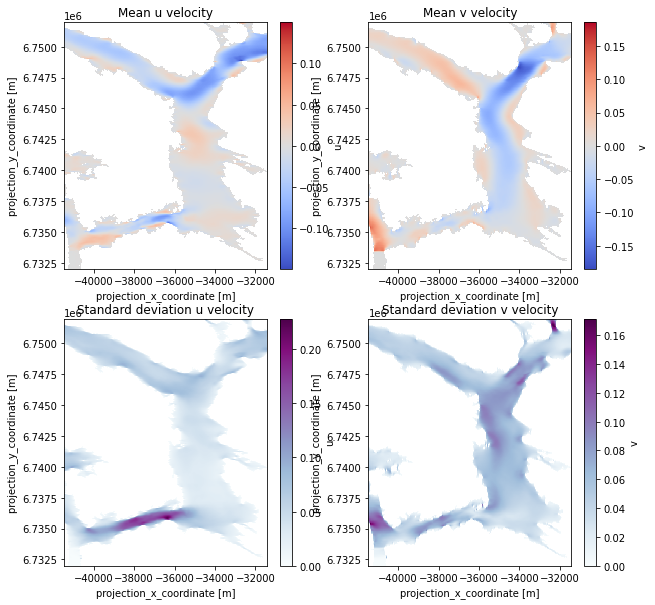

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
cmap='coolwarm'
cmap_std='BuPu'
surface.u.mean(dim='time').where(surface.land_binary_mask==0).plot(ax=axes[0,0],cmap=cmap)
axes[0,0].set_title('Mean u velocity')
surface.v.mean(dim='time').where(surface.land_binary_mask==0).plot(ax=axes[0,1],cmap=cmap)
axes[0,1].set_title('Mean v velocity')
surface.u.std(dim='time').where(surface.land_binary_mask==0).plot(ax=axes[1,0],cmap=cmap_std)
axes[1,0].set_title('Standard deviation u velocity')
surface.v.std(dim='time').where(surface.land_binary_mask==0).plot(ax=axes[1,1],cmap=cmap_std)
axes[1,1].set_title('Standard deviation v velocity')


Text(0.5, 1.0, 'Correlation u and v')

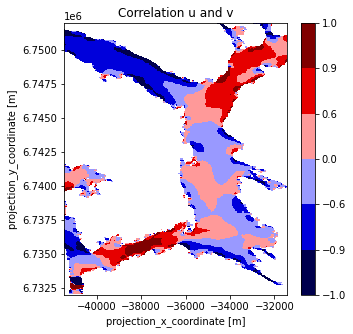

In [8]:
fig, axes = plt.subplots(ncols=1, figsize=(5,5))
xr.corr(surface.u,surface.v,dim='time').plot(vmin=-1,vmax=1,levels=[-1,-0.9,-0.6,0,0.6,0.9,1],cmap='seismic',ax=axes)
axes.set_title('Correlation u and v')


Focusing, jump over if not. 

In [9]:
surface=surface.sel(Y=slice(6733400,6737500),X=slice(-40000,-35000))

## EOF analysis

* First centralize the velocity components, i.e. subtract mean in time at each point, 
* stack the spatial coordinates.
* create mask based on *land_binary_mask*
* delete land points


In [10]:
u=(surface.u-surface.u.mean(dim='time')).stack(z=['Y','X'])
v=(surface.v-surface.v.mean(dim='time')).stack(z=['Y','X'])

mask=surface.land_binary_mask.stack(z=['Y','X']).data
u

<xarray.DataArray 'u' (time: 1501, z: 8200)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.00829574,
         0.01107276,  0.01415242],
       [ 0.        ,  0.        ,  0.        , ..., -0.01169896,
        -0.01194207, -0.01234291],
       [ 0.        ,  0.        ,  0.        , ..., -0.03332882,
        -0.03961261, -0.04535262],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.01703226,
        -0.02055215, -0.02246573],
       [ 0.        ,  0.        ,  0.        , ..., -0.02017952,
        -0.02099931, -0.02260068],
       [ 0.        ,  0.        ,  0.        , ..., -0.00620791,
         0.001449  ,  0.00779194]], dtype=float32)
Coordinates:
    depth    float32 1.0
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-16T18:40:00
  * z        (z) MultiIndex
  - Y        (z) float64 6.733e+06 6.733e+06 6.733e+06 ... 6.737e+06 6.737e+06
  - X        (z) float64 -3.999e+04 -3.994e+04 ... -3.509e+04 -3.504e+04

In [11]:

u=u.where(mask==0).dropna(dim='z')
v=v.where(mask==0).dropna(dim='z')

In [12]:
u

<xarray.DataArray 'u' (time: 1501, z: 3495)>
array([[-0.00169003, -0.0016421 , -0.00416864, ...,  0.00829574,
         0.01107276,  0.01415242],
       [ 0.00406515,  0.00527349,  0.00166109, ..., -0.01169896,
        -0.01194207, -0.01234291],
       [-0.00182895, -0.00138323, -0.00017523, ..., -0.03332882,
        -0.03961261, -0.04535262],
       ...,
       [ 0.01122505,  0.00889005,  0.00852145, ..., -0.01703226,
        -0.02055215, -0.02246573],
       [ 0.00614687,  0.00661771,  0.00604855, ..., -0.02017952,
        -0.02099931, -0.02260068],
       [ 0.00142816,  0.00265064,  0.0052536 , ..., -0.00620791,
         0.001449  ,  0.00779194]], dtype=float32)
Coordinates:
    depth    float32 1.0
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-16T18:40:00
  * z        (z) MultiIndex
  - Y        (z) float64 6.734e+06 6.734e+06 6.734e+06 ... 6.737e+06 6.737e+06
  - X        (z) float64 -3.959e+04 -3.954e+04 ... -3.509e+04 -3.504e+04

Create the covariance matrix

$$ C = P^T S
$$

where $P$ and $S$ contains, respectively, the u and v time series 

Here N and *randomstate* is only used if we use randomized_svd in the next step. 

In [13]:
C=u.data.T@v.data
N=20
random_state=0

Do the SVD analysis.

In [14]:
U,L,Vt=np.linalg.svd(C)#randomized_svd(C,N,random_state=random_state)

Calculate the principal components 
$$ A = P U \\ B= S U$$

In [15]:
A=u.data@U
B=v.data@Vt.T

Put all into a xarray

In [16]:
res=xr.Dataset(coords=u.coords)

res['U']=(('z','mode'),U)
res['V']=(('z','mode'),Vt.T)
res['L']=(('mode'),L)
res['A']=(('time','mode'),A)
res['B']=(('time','mode'),B)
res

<xarray.Dataset>
Dimensions:  (time: 1501, z: 3495, mode: 3495)
Coordinates:
    depth    float32 1.0
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-16T18:40:00
  * z        (z) MultiIndex
  - Y        (z) float64 6.734e+06 6.734e+06 6.734e+06 ... 6.737e+06 6.737e+06
  - X        (z) float64 -3.959e+04 -3.954e+04 ... -3.509e+04 -3.504e+04
Dimensions without coordinates: mode
Data variables:
    U        (z, mode) float32 -9.04e-06 -0.0003513 ... 1.156e-16 1.947e-18
    V        (z, mode) float32 0.0001476 0.0004686 ... -0.00666 -0.001708
    L        (mode) float32 1.471e+04 3.957e+03 946.1 ... 1.102e-12 1.102e-12
    A        (time, mode) float32 10.65 -2.288 0.1283 ... 7.001e-21 3.076e-24
    B        (time, mode) float32 4.159 -0.7982 0.2008 ... -1.029e-06 3.092e-07

### The singular values

(0.0, 20.0)

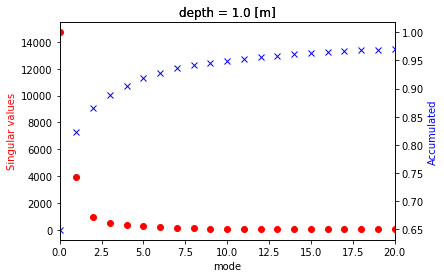

In [17]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
res.L.plot.line('ro',ax=ax1)
(res.L.cumsum()/res.L.sum()).plot.line('bx',ax=ax2)
ax2.set_ylabel('Accumulated', color='b')
ax1.set_ylabel('Singular values', color='r')
plt.xlim(0,20)


Keeping 20 modes. Calculate reconstructed fields and put the original fields into *res*. 

In [18]:
res=res.isel(mode=slice(0,20))
res['usvd']=(('time','z'),res.A.data@res.U.data.T)
res['vsvd']=(('time','z'),res.B.data@res.V.data.T)
res['u']=u
res['v']=v
res

<xarray.Dataset>
Dimensions:  (time: 1501, z: 3495, mode: 20)
Coordinates:
    depth    float32 1.0
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-16T18:40:00
  * z        (z) MultiIndex
  - Y        (z) float64 6.734e+06 6.734e+06 6.734e+06 ... 6.737e+06 6.737e+06
  - X        (z) float64 -3.959e+04 -3.954e+04 ... -3.509e+04 -3.504e+04
Dimensions without coordinates: mode
Data variables:
    U        (z, mode) float32 -9.04e-06 -0.0003513 ... 0.008366 0.0104
    V        (z, mode) float32 0.0001476 0.0004686 ... 0.0002186 -0.0008546
    L        (mode) float32 1.471e+04 3.957e+03 946.1 ... 36.43 34.67 31.78
    A        (time, mode) float32 10.65 -2.288 0.1283 ... -0.6409 0.3932 0.2048
    B        (time, mode) float32 4.159 -0.7982 0.2008 ... -0.3278 0.5156 0.4159
    usvd     (time, z) float32 0.001035 0.001299 -0.001963 ... 0.009228 0.01178
    vsvd     (time, z) float32 -0.0009615 0.002106 0.001715 ... -0.2863 -0.271
    u        (time, z) float32 -0.00169 -0.001642 ... 0.001449 0.007792
    v        (time, z) float32 0.002451 0.002367 0.003316 ... -0.2541 -0.2589

Can look at the results. 

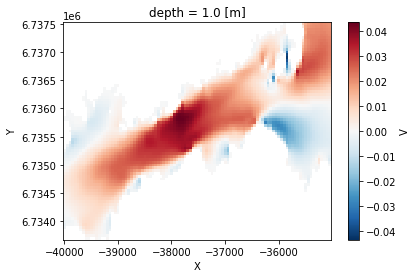

In [19]:
res.V.isel(mode=0).unstack('z').plot()

At specific times.

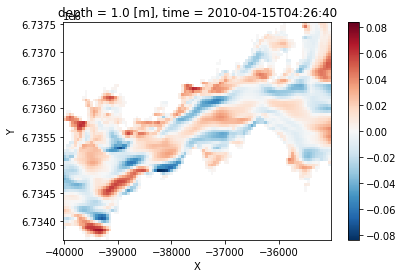

In [20]:
(res.usvd-res.u).isel(time=250).unstack('z').plot()

Statistics.

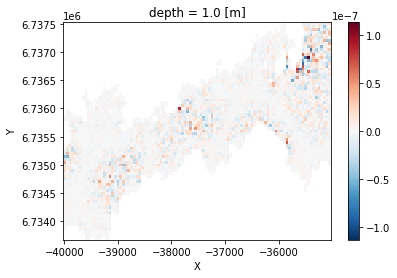

In [21]:
(res.vsvd-res.v).mean(dim='time').unstack('z').plot()

In [36]:
res[['A','B','U','V','L']].unstack('z').to_netcdf('test.nc')

In [37]:
res[['u','v']].unstack('z').to_netcdf('testu.nc')

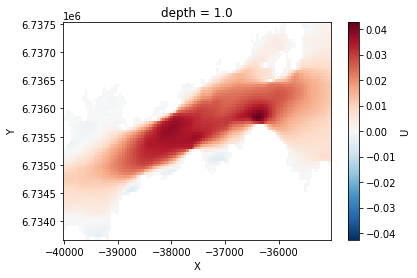

In [22]:
res.U.isel(mode=0).unstack('z').plot()

In [23]:
res=res.isel(mode=np.arange(0,20))

## Correlation plots

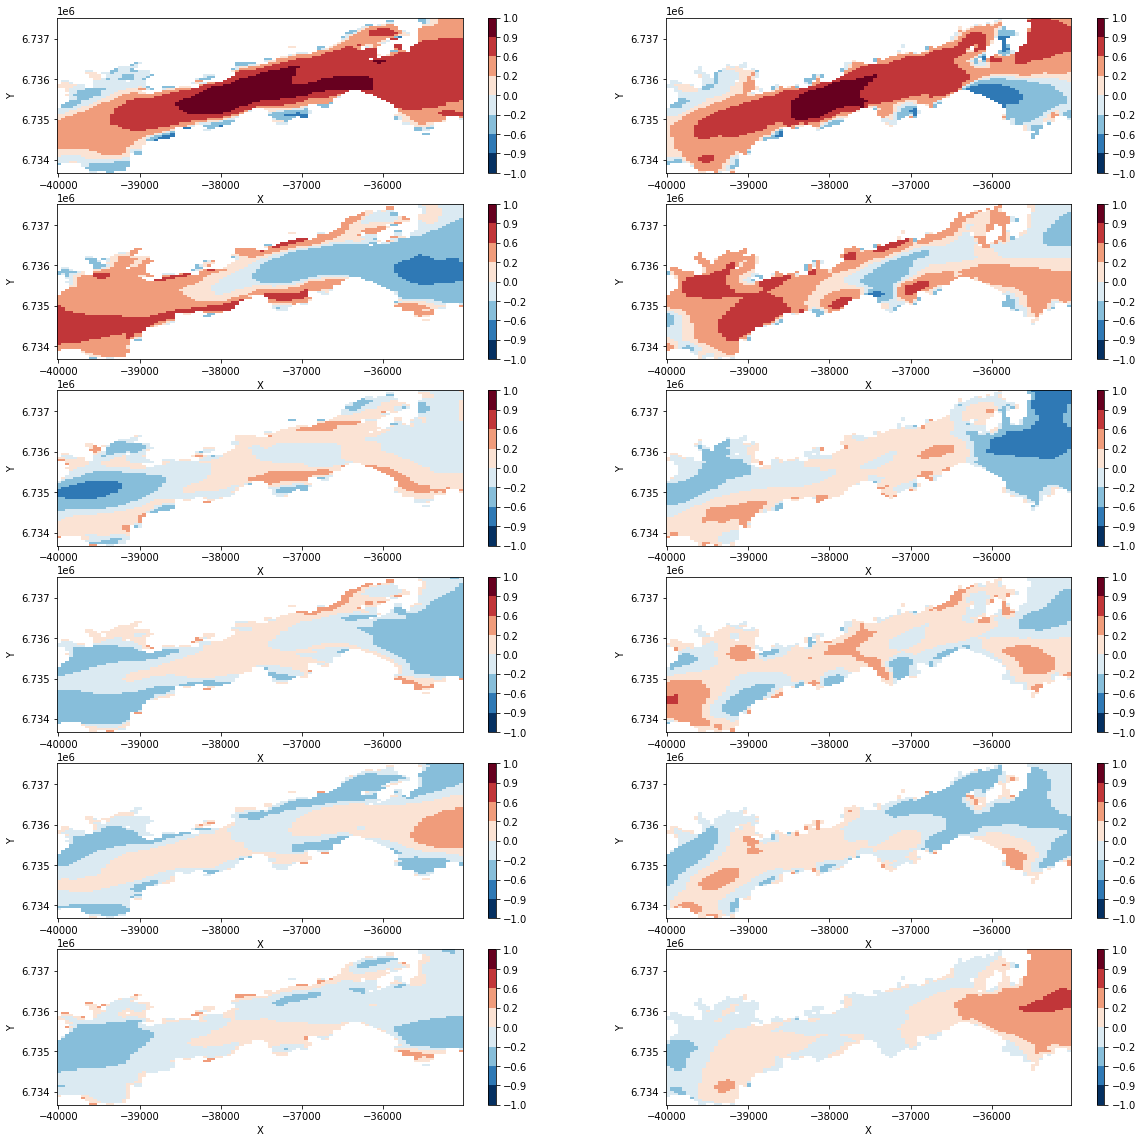

In [22]:
nmodes=6
modes=np.arange(0,nmodes)
tmp=res.isel(mode=0).drop('depth')
fig,axes=plt.subplots(ncols=2,nrows=nmodes,figsize=(20,20))
levels=[-1,-0.9,-0.6,-0.2,0,0.2,0.6,0.9,1]
for mode in modes:
    tmp=res.isel(mode=mode).drop('depth')
    xr.corr(tmp.A,tmp.u,dim='time').unstack('z').plot(ax=axes[mode,0],levels=levels)
    xr.corr(tmp.B,tmp.v,dim='time').unstack('z').plot(ax=axes[mode,1],levels=levels)


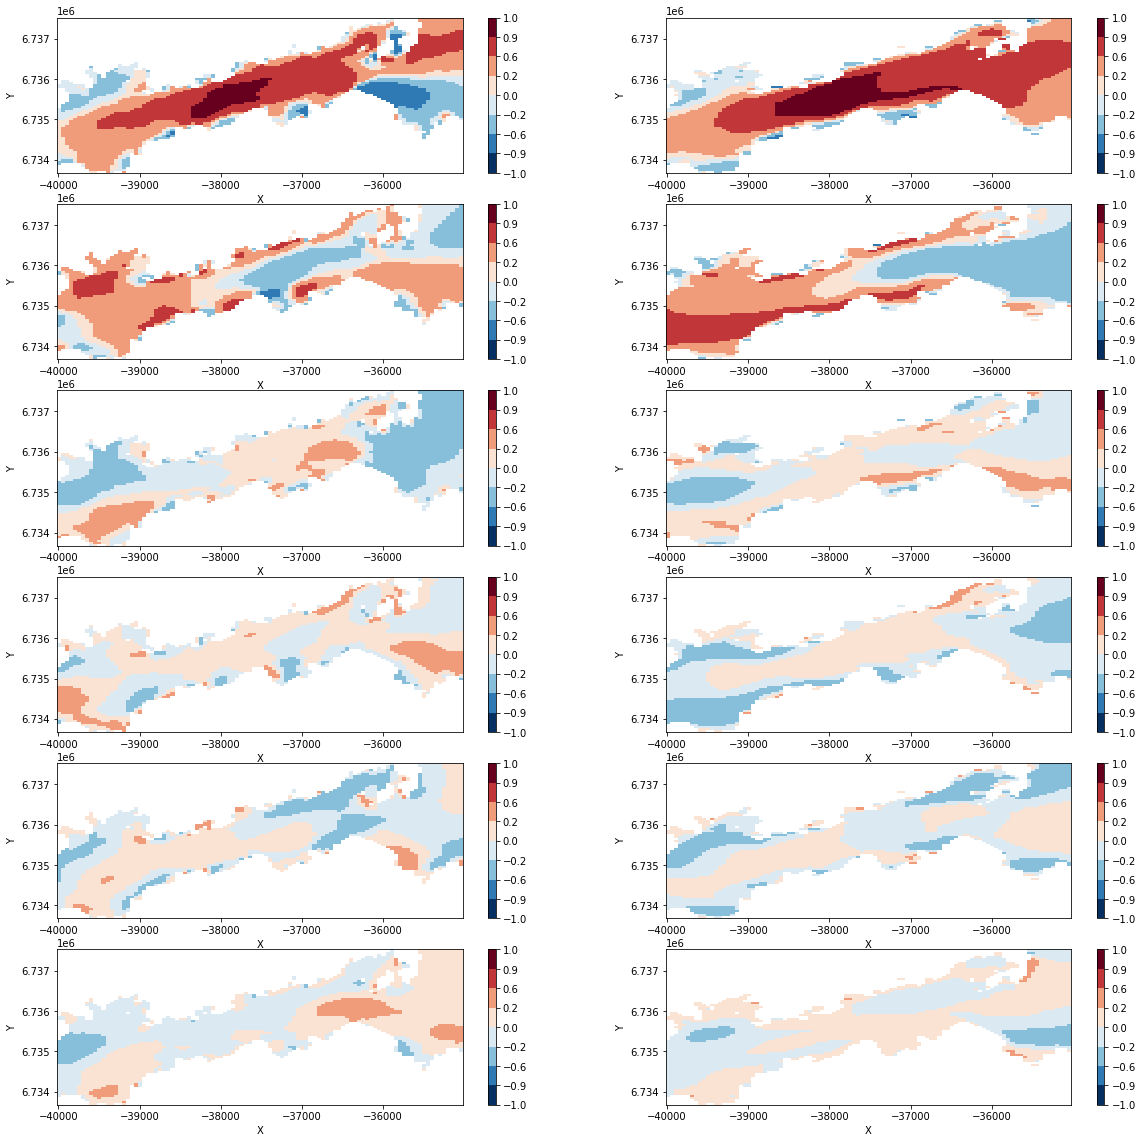

In [23]:
nmodes=6
modes=np.arange(0,nmodes)
tmp=res.isel(mode=0).drop('depth')
fig,axes=plt.subplots(ncols=2,nrows=nmodes,figsize=(20,20))
levels=[-1,-0.9,-0.6,-0.2,0,0.2,0.6,0.9,1]
for mode in modes:
    tmp=res.isel(mode=mode).drop('depth')
    xr.corr(tmp.A,tmp.v,dim='time').unstack('z').plot(ax=axes[mode,0],levels=levels)
    xr.corr(tmp.B,tmp.u,dim='time').unstack('z').plot(ax=axes[mode,1],levels=levels)

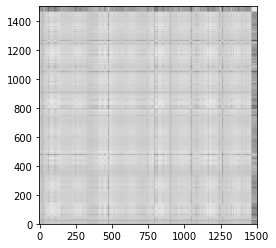

In [53]:
ts=res.A.isel(mode=0).data.reshape(1, -1)
rcp=RecurrencePlot()
#ts_new=rcp.fit(ts.data.T)
ts_new=rcp.transform(ts)
trsh=np.percentile(
    np.reshape(ts_new,(1501,-1)),
    np.arange(1,100),axis=1
    )
trsh.size
plt.imshow(ts_new[0],cmap='binary',origin='lower')

## Time series
Focus on the time variability. Resample to a period of 1 hour. 

In [24]:
pcs=res[['A','B']].drop('depth').resample(time='H').interpolate()
pcs

<xarray.Dataset>
Dimensions:  (time: 2667, mode: 20)
Coordinates:
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-16T18:00:00
Dimensions without coordinates: mode
Data variables:
    A        (time, mode) float64 10.65 -2.288 0.1283 ... -0.544 0.3785 -0.05084
    B        (time, mode) float64 4.159 -0.7982 0.2008 ... 0.3662 0.05784

###  Scatter plots

The modes are uncorrelated, however *A* and *B* are correlated for the same *mode*

<AxesSubplot:xlabel='A', ylabel='A'>

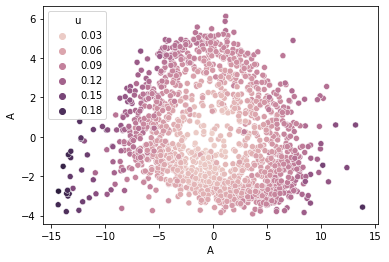

In [36]:
mode1=0
mode2=1#mode1
sns.scatterplot(x=res.A.isel(mode=mode1),y=res.A.isel(mode=mode2),hue=res.u.std('z'))

### autocorrelation

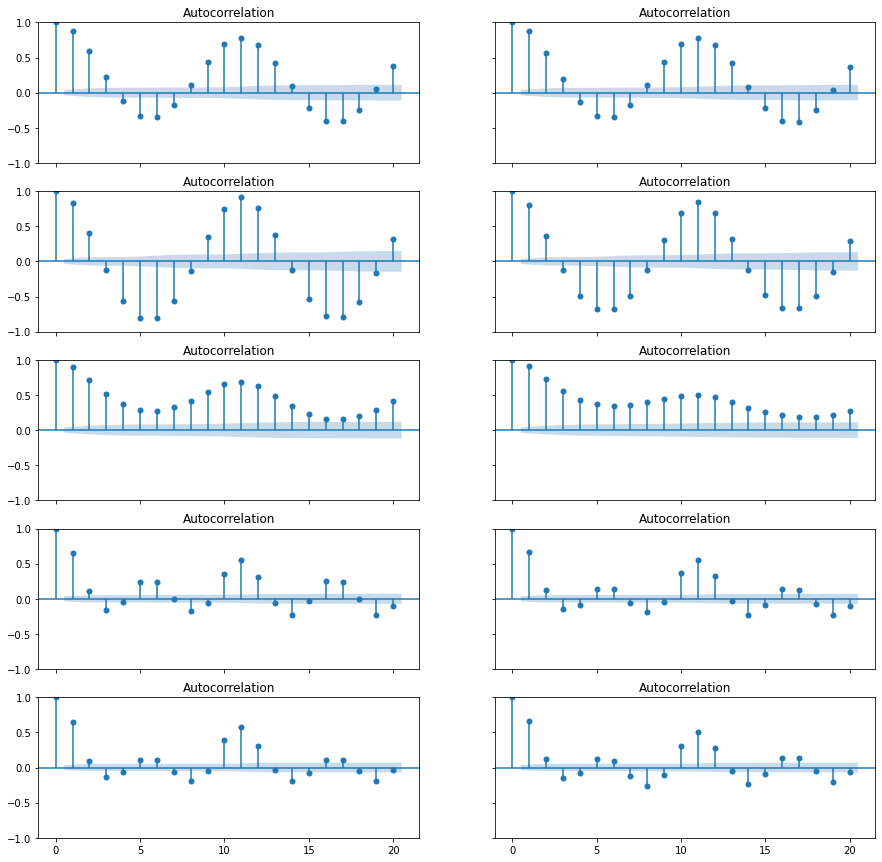

In [41]:
rows=5
lags=20
levels=[-1,-0.9,-0.7,-0.5,-0.3,0,0.3,0.5,0.7,0.9,1]
cmap='coolwarm'
fig, axes = plt.subplots(ncols=2, nrows=rows, figsize=(15,15),sharex=True,sharey=True)

for ii in np.arange(rows):
    plot_acf(pcs.A.isel(mode=ii).data,lags=lags,ax=axes[ii,0])
    plot_acf(pcs.B.isel(mode=ii).data,lags=lags,ax=axes[ii,1])

## FFT

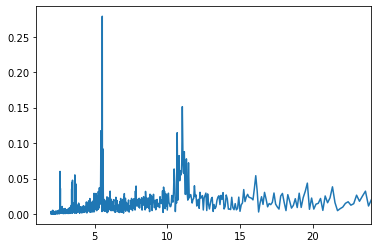

In [92]:
from scipy.fft import fft, fftfreq
modes=[4]
for ii in modes:
    signal =pcs.A.isel(mode=ii)
    N=np.size(signal)
    T=1#((signal.time[-1]-signal.time[0])/np.timedelta64(1, 'h')).data
    y=fft(signal.data)
    y=2.0/N * np.abs(y[0:N//2-1])
    x=(fftfreq(N, T)[:N//2-1])
    x=1/(x+1e-9)
    plt.plot(x,y)
    plt.xlim(1,24)

In [88]:
pcs.time

<xarray.DataArray 'time' (time: 2667)>
array(['2010-03-27T16:00:00.000000000', '2010-03-27T17:00:00.000000000',
       '2010-03-27T18:00:00.000000000', ..., '2010-07-16T16:00:00.000000000',
       '2010-07-16T17:00:00.000000000', '2010-07-16T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-16T18:00:00
Attributes:
    long_name:      time since initialization
    field:          time, scalar, series
    axis:           T
    standard_name:  time

(10.0, 13.0)

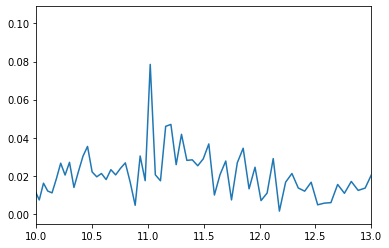

In [84]:
pks,_=sp.signal.find_peaks(y,height=0.5)


plt.plot(x,y)
plt.plot(x[pks],y[pks],'x')
plt.xlim(10,13)

In [69]:
pks

array([  3,   6,   8,  12,  15,  19,  26,  30,  70, 237, 242, 250])

### Continuous Wavelet

In [115]:
pywt.frequency2scale('cmor-0.5-5.0',1)

5.0

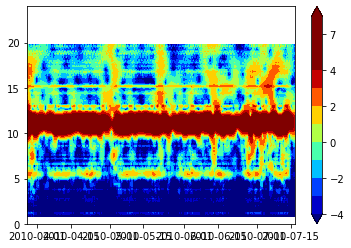

In [117]:
ts=pcs.A.sel(mode=1)#.isel(time=slice(100,164))

wavelet = 'cmor-0.5-5.0'
minscale=pywt.frequency2scale(wavelet,10)
maxscale=pywt.frequency2scale(wavelet,0.05)

scales = np.arange(4, 100)

[cfs, freq]=pywt.cwt(ts.data,scales, wavelet)#,dt)
power=np.abs(cfs)**2
period=1/freq
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 64, 128, 256]

#f, ax = plt.subplots(figsize=(20, 10))
plt.contourf(ts.time, period, np.log2(power[:,:]), np.log2(levels),
            cmap = plt.cm.jet,extend='both',vmax=4)
plt.ylim(0,24)
plt.colorbar()

## Filter

In [3]:
help(sm.tsa.filters.bkfilter)

Help on function bkfilter in module statsmodels.tsa.filters.bk_filter:

bkfilter(x, low=6, high=32, K=12)
    Filter a time series using the Baxter-King bandpass filter.
    
    Parameters
    ----------
    x : array_like
        A 1 or 2d ndarray. If 2d, variables are assumed to be in columns.
    low : float
        Minimum period for oscillations, ie., Baxter and King suggest that
        the Burns-Mitchell U.S. business cycle has 6 for quarterly data and
        1.5 for annual data.
    high : float
        Maximum period for oscillations BK suggest that the U.S.
        business cycle has 32 for quarterly data and 8 for annual data.
    K : int
        Lead-lag length of the filter. Baxter and King propose a truncation
        length of 12 for quarterly data and 3 for annual data.
    
    Returns
    -------
    ndarray
        The cyclical component of x.
    
    See Also
    --------
    statsmodels.tsa.filters.cf_filter.cffilter
        The Christiano Fitzgerald asymmetric,

In [2]:
import statsmodels.api as sm
signal =pcs.A.isel(mode=0)
fsig=sm.tsa.filters.bkfilter(signal,low=10,high=36)
plt.plot(signal[12:-12],label='raw')
plt.plot(fsig, label='fsig')

plt.plot(signal[12:-12]-fsig,label='diff')
plt.legend()
plt.xlim(100,224)

NameError: name 'pcs' is not defined

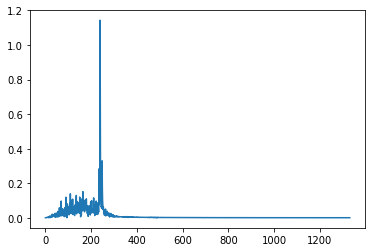

In [94]:
plt.plot(2.0/N * np.abs(fft(fsig)[0:N//2-1]))

In [575]:
np.shape(signal)[0]-np.shape(fsig)[0]


24

In [527]:
signal.time[-1]

<xarray.DataArray 'time' ()>
array('2010-07-16T18:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2010-07-16T18:00:00
Attributes:
    long_name:      time since initialization
    field:          time, scalar, series
    axis:           T
    standard_name:  time

In [43]:
help(res.plot)

Help on method plot in module statsmodels.tsa.seasonal:

plot(observed=True, seasonal=True, trend=True, resid=True, weights=False) method of statsmodels.tsa.seasonal.DecomposeResult instance
    Plot estimated components
    
    Parameters
    ----------
    observed : bool
        Include the observed series in the plot
    seasonal : bool
        Include the seasonal component in the plot
    trend : bool
        Include the trend component in the plot
    resid : bool
        Include the residual in the plot
    weights : bool
        Include the weights in the plot (if any)
    
    Returns
    -------
    matplotlib.figure.Figure
        The figure instance that containing the plot.



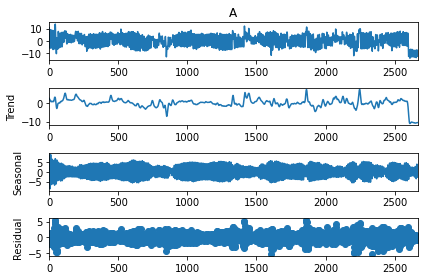

In [46]:
from statsmodels.tsa.seasonal import STL
ts=pcs.A.sel(mode=0)
res=STL(ts,period=12).fit()
fig=res.plot()
#plt.xlim(200,224)

In [50]:
for ax in fig.axes: 
    ax.set_xlim(200,224)

fig.show()


/var/folders/0q/9km71d951t92fm7tt48bvzlw0000gr/T/ipykernel_28039/2513812543.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


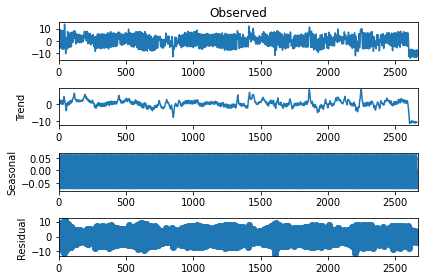

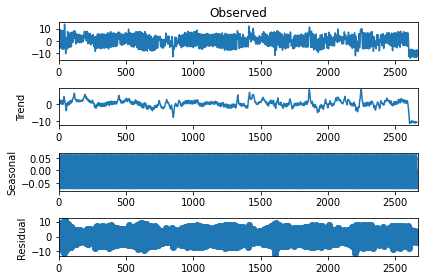

In [208]:
tmpA=seasonal_decompose(ts, model='additive', period=13)
tmpA.plot()

In [119]:
from statsmodels.tsa.seasonal import seasonal_decompose
period=7
decomp=pcs.copy()
decomp['A_trend']=xr.zeros_like(decomp['A'])
decomp['A_seas']=xr.zeros_like(decomp['A'])
decomp['A_resid']=xr.zeros_like(decomp['A'])
decomp['B_trend']=xr.zeros_like(decomp['B'])
decomp['B_seas']=xr.zeros_like(decomp['B'])
decomp['B_resid']=xr.zeros_like(decomp['B'])
decomp['A_trend'].loc[dict(mode=0)]=seas.trend
decomp.A_trend.isel(mode=0)

for mode in pcs.mode:
    tmpA=seasonal_decompose(pcs.A.isel(mode=mode).data, model='additive', period=period)
    decomp['A_trend'].loc[dict(mode=mode)]=tmpA.trend
    decomp['A_seas'].loc[dict(mode=mode)]=tmpA.seasonal
    decomp['A_resid'].loc[dict(mode=mode)]=tmpA.resid
    tmpB=seasonal_decompose(pcs.A.isel(mode=mode).data, model='additive', period=period)
    decomp['B_trend'].loc[dict(mode=mode)]=tmpB.trend
    decomp['B_seas'].loc[dict(mode=mode)]=tmpB.seasonal
    decomp['B_resid'].loc[dict(mode=mode)]=tmpB.resid

In [120]:
decomp

<xarray.Dataset>
Dimensions:  (time: 1501, mode: 20)
Coordinates:
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-16T18:40:00
Dimensions without coordinates: mode
Data variables:
    A        (time, mode) float32 10.65 -2.288 0.1283 ... -0.6409 0.3932 0.2048
    B        (time, mode) float32 4.159 -0.7982 0.2008 ... -0.3278 0.5156 0.4159
    A_trend  (time, mode) float32 nan nan nan nan nan ... nan nan nan nan nan
    A_seas   (time, mode) float32 -0.093 -0.06873 0.01164 ... -0.005305 -0.01658
    A_resid  (time, mode) float32 nan nan nan nan nan ... nan nan nan nan nan
    B_trend  (time, mode) float32 nan nan nan nan nan ... nan nan nan nan nan
    B_seas   (time, mode) float32 -0.093 -0.06873 0.01164 ... -0.005305 -0.01658
    B_resid  (time, mode) float32 nan nan nan nan nan ... nan nan nan nan nan

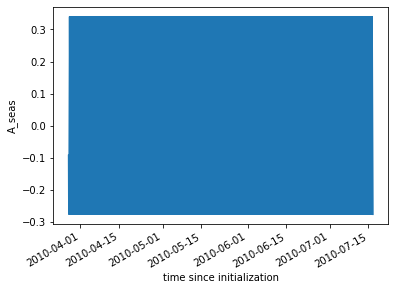

In [121]:
decomp.A_seas.isel(mode=0).plot()

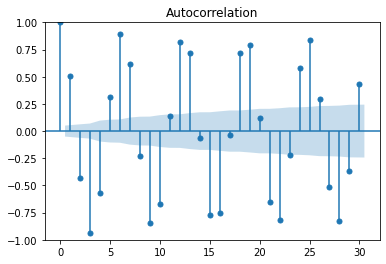

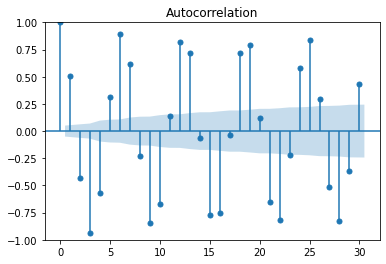

In [122]:
plot_acf(decomp.A_resid.dropna(dim='time').isel(mode=0),lags=30)

(110.0, 230.0)

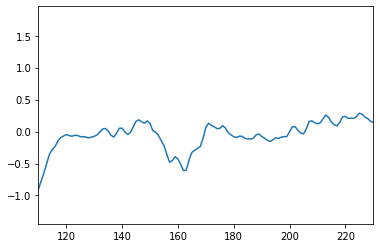

In [86]:
plt.plot(seas.trend)
plt.xlim(110,230)

## EMD

In [215]:
emd = EMD()
emd.emd(ts.data, ts.time)
imfs, resid = emd.get_imfs_and_residue()

UFuncTypeError: ufunc 'true_divide' cannot use operands with types dtype('float64') and dtype('<m8[ns]')

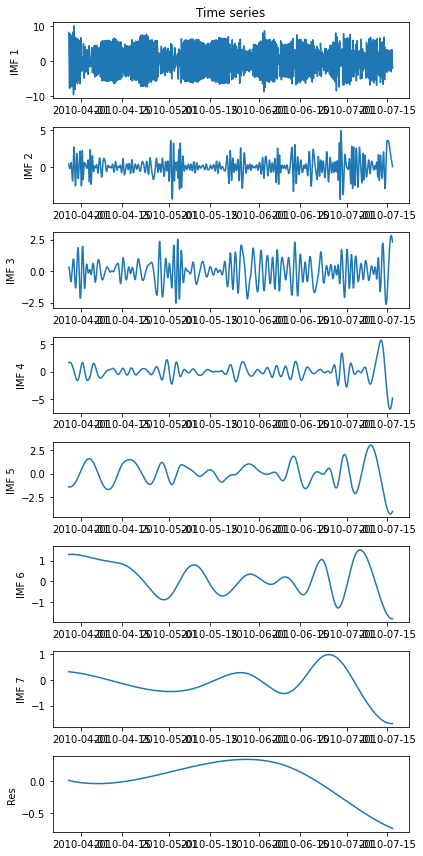

In [216]:
vis = Visualisation()
vis.plot_imfs(imfs=imfs, residue=resid, t=ts.time, include_residue=True)
vis.plot_instant_freq(ts.time, imfs=imfs)
vis.show()

## SSA

Help on class SingularSpectrumAnalysis in module pyts.decomposition.ssa:

class SingularSpectrumAnalysis(sklearn.base.BaseEstimator, pyts.base.UnivariateTransformerMixin)
 |  SingularSpectrumAnalysis(window_size=4, groups=None)
 |  
 |  Singular Spectrum Analysis.
 |  
 |  Parameters
 |  ----------
 |  window_size : int or float (default = 4)
 |      Size of the sliding window (i.e. the size of each word). If float, it
 |      represents the percentage of the size of each time series and must be
 |      between 0 and 1. The window size will be computed as
 |      ``max(2, ceil(window_size * n_timestamps))``.
 |  
 |  groups : None, int or array-like (default = None)
 |      The way the elementary matrices are grouped. If None, no grouping is
 |      performed. If an integer, it represents the number of groups and the
 |      bounds of the groups are computed as
 |      ``np.linspace(0, window_size, groups + 1).astype('int64')``.
 |      If array-like, each element must be array-like an

In [224]:
ts

<xarray.DataArray 'A' (time: 2667)>
array([ 10.6495657 ,   7.9570224 ,   5.08476961, ..., -10.72760105,
       -12.23885781, -12.80230677])
Coordinates:
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-16T18:00:00

In [228]:
from pyts.decomposition import SingularSpectrumAnalysis
ssa=SingularSpectrumAnalysis(window_size=4,groups=3)
#ts=pcs.A.isel(mode=0).data.reshape(1, -1)
X_ssa=ssa.fit_transform(ts.data.reshape(1, -1))

In [227]:
help(ssa)

Help on SingularSpectrumAnalysis in module pyts.decomposition.ssa object:

class SingularSpectrumAnalysis(sklearn.base.BaseEstimator, pyts.base.UnivariateTransformerMixin)
 |  SingularSpectrumAnalysis(window_size=4, groups=None)
 |  
 |  Singular Spectrum Analysis.
 |  
 |  Parameters
 |  ----------
 |  window_size : int or float (default = 4)
 |      Size of the sliding window (i.e. the size of each word). If float, it
 |      represents the percentage of the size of each time series and must be
 |      between 0 and 1. The window size will be computed as
 |      ``max(2, ceil(window_size * n_timestamps))``.
 |  
 |  groups : None, int or array-like (default = None)
 |      The way the elementary matrices are grouped. If None, no grouping is
 |      performed. If an integer, it represents the number of groups and the
 |      bounds of the groups are computed as
 |      ``np.linspace(0, window_size, groups + 1).astype('int64')``.
 |      If array-like, each element must be array-like a

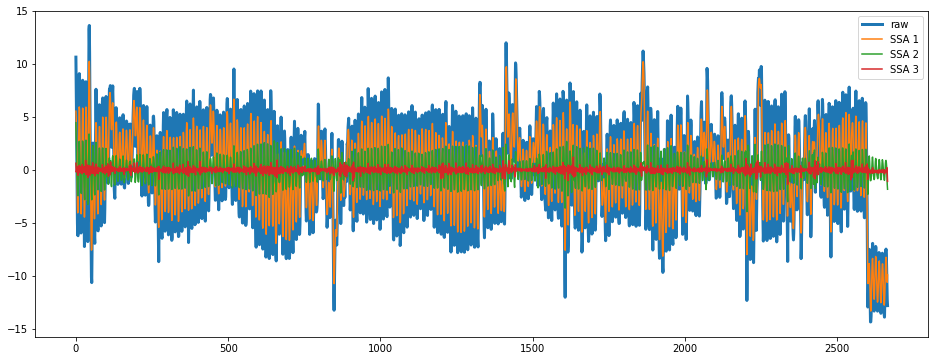

In [230]:
from cProfile import label


plt.figure(figsize=(16,6))
ax1=plt.subplot(111)
ax1.plot(ts.data,linewidth=3,label='raw')
#plt.xlim(300,450)
ax2=plt.subplot(111)
for i in range(np.shape(X_ssa)[0]):
    ax2.plot(X_ssa[i,:],label='SSA {0}'.format(i+1))
ax2.legend(loc='best')
#plt.xlim(300,450)

In [ ]:
res.isel(mode=0)

<xarray.Dataset>
Dimensions:  (time: 1501, z: 28375)
Coordinates:
    depth    float32 1.0
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-16T18:40:00
  * z        (z) MultiIndex
  - Y        (z) float64 6.732e+06 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  - X        (z) float64 -4.124e+04 -4.119e+04 ... -3.219e+04 -3.214e+04
Data variables:
    U        (z) float32 -5.331e-11 -1.074e-13 6.134e-14 ... 0.0004857 0.0001407
    V        (z) float32 3.949e-11 6.703e-14 4.897e-17 ... -0.003026 -0.001298
    L        float32 3.316e+04
    A        (time) float32 10.33 8.738 3.418 -2.617 ... -13.59 -16.11 -17.61
    B        (time) float32 7.25 6.979 4.223 1.694 ... -13.5 -15.64 -15.87
    usvd     (time, z) float32 -1.058e-05 -6.445e-07 ... -0.0269 -0.007757
    vsvd     (time, z) float32 4.598e-07 -1.591e-07 ... 0.05575 -0.005245
    u        (time, z) float32 0.0 0.0 0.0 0.0 ... -0.04315 -0.02562 -0.007379
    v        (time, z) float32 0.0 0.0 0.0 0.0 ... 0.03503 0.03074 0.01637

<AxesSubplot:>

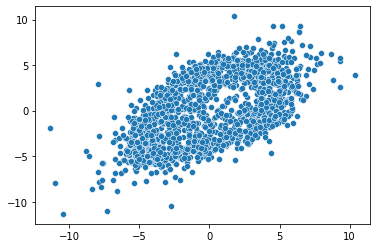

In [ ]:
mode=1
sns.scatterplot(x=res.isel(mode=mode).A.data,y=res.isel(mode=mode).A.shift(time=1).data)

In [ ]:
from pyts.bag_of_words import BagOfWords
ts=res.A.isel(mode=0).data.reshape(1, -1)

bow=BagOfWords()
ts_bow=bow.transform(ts)


In [ ]:
from pyts.classification import LearningShapelets
clf=LearningShapelets()
clf.fit(ts)

TypeError: fit() missing 1 required positional argument: 'y'

In [ ]:
from pyts.approximation import DiscreteFourierTransform
dft=DiscreteFourierTransform(n_coefs=10)
ts_dft=dft.fit_transform(ts)

In [ ]:
ts_dft

array([[-9.76864249e-06, -7.80601785e+01,  2.94103783e+02,
        -9.90119212e+01, -5.26587478e+02, -9.55641453e+02,
        -4.56565238e+02, -4.94915414e+02, -2.92294210e+02,
         2.63048001e+02]])

## Wavelets

In [463]:
from collections import Counter
from pywt import wavedecn
import pywt
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=sp.stats.entropy(probabilities)
    return entropy
 
def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]
 
def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]
 
def get_features(list_values):
    entropy = calculate_entropy(list_values)
    #crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return  [entropy] + statistics #[entropy] + crossings + statistics

def pcs_to_features(xarr,modes=None, wavelet='db5',level=4):
    features = []
    
    if modes == None:
        modes=xarr.sizes['mode']
    length=xarr.sizes['time']
    print('length',length)
    print(pywt.dwt_max_level(length, wavelet))
    level=min(pywt.dwt_max_level(length, wavelet),level)
    for mode in range(0, modes):
        signal = xarr.isel(mode=mode)
        list_coeff = pywt.wavedec(signal,wavelet=wavelet, level=level)
        for coeff in list_coeff:
                features += get_features(coeff)
        features.append(features)
    
    return np.array(features)

def pick_random(xarr, length=124):
    max_start=xarr.sizes['time']-length
    start=randrange(0,100)#max_start)
    out=xarr.isel(time=slice(start,start+length))
    return out#, start

def get_features_n(data):
    #coeffs, axes, ndim, ndim_transform=pywt.coeffs_to_array(data,axes=0)
    features=[]
    for ii in range(1,len(data)):
        for jj in range(np.shape(data[ii]['d'])[1]):
       # print(ii,jj)
            features +=get_features(data[ii]['d'][:,jj])
    return features    

In [501]:
matrix=[]
start=[]
length=64
num=400
max_start=pcs.sizes['time']-length
starts=randint(0,max_start,num)


for start in starts:
    ts=pcs.A.isel(mode=slice(0,6)).isel(time=slice(start,start+length))
    tmp=wavedecn(ts.data,axes=0,wavelet='db8')
    tmp=get_features_n(tmp)
    #tmp=pywt.coeffs_to_array(tmp,axes=0)
    matrix.append(tmp)

matrix=np.asarray(matrix)
    

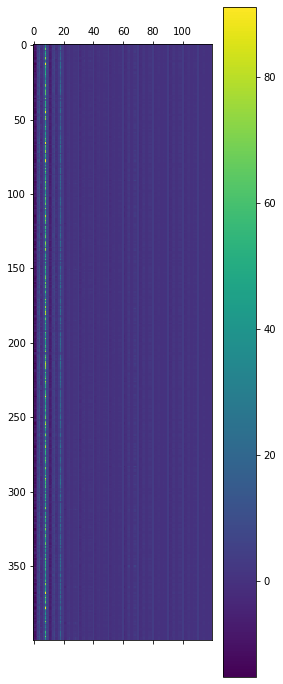

In [502]:
plt.matshow(matrix)
plt.colorbar()

In [503]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
#matrix= StandardScaler().fit_transform(matrix)
db = DBSCAN(eps=5, min_samples=3).fit(matrix)

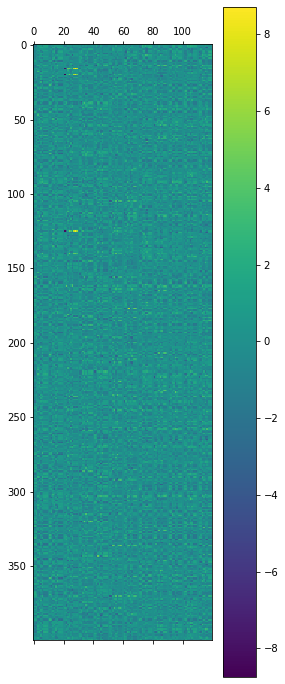

In [497]:
plt.matshow(matrix)
plt.colorbar()

In [504]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
# print(
#     "Adjusted Mutual Information: %0.3f"
#     % metrics.adjusted_mutual_info_score(labels_true, labels)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(matrix, labels))

Estimated number of clusters: 5
Estimated number of noise points: 30
Silhouette Coefficient: -0.007


In [505]:
labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4, -1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0,
        0,  0,  0,  2,  0,  0,  0,  0,  0,  3,  4,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  3,  0,  3,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,
       -1,  0,  2,  0,  0,  0,  0, -1,  0,  0,  3,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [506]:

Counter(labels).most_common()

[(0, 355), (-1, 30), (1, 4), (2, 4), (3, 4), (4, 3)]

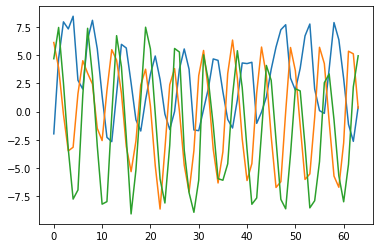

In [491]:
indx=np.where(labels==3)[0]
for ii in indx:
    plt.plot(pcs.A.isel(time=slice(ii,ii+length)).isel(mode=0).data)

In [528]:
(signal.time[-1]-signal.time[0])/np.timedelta64(1, 'h')

<xarray.DataArray 'time' ()>
array(2666.)

## Low pass filter

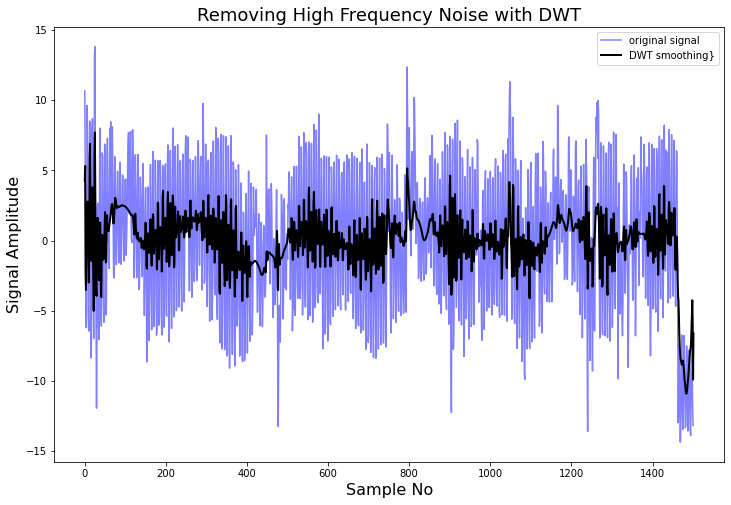

In [507]:
signal =pcs.A.isel(mode=0)
def lowpassfilter(signal, thresh = 0.63, wavelet="db4"):
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    return reconstructed_signal
 
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(signal, color="b", alpha=0.5, label='original signal')
rec = lowpassfilter(signal, 0.5)
ax.plot(rec, 'k', label='DWT smoothing}', linewidth=2)
ax.legend()
ax.set_title('Removing High Frequency Noise with DWT', fontsize=18)
ax.set_ylabel('Signal Amplitude', fontsize=16)
ax.set_xlabel('Sample No', fontsize=16)
plt.show()

In [427]:
plt.plot(signal-rec)

ValueError: operands could not be broadcast together with shapes (1501,) (1502,) 

In [19]:
import pywt
time=res.time.data
dt=((time[1]-time[0]))/np.timedelta64(1, 'h')
dt

1.7777777777777777

In [20]:

wavelet = 'haar'
scales = np.arange(4, 100)
f=pywt.scale2frequency('cmor0.5-1.0', 7)/dt
f


0.08035714285714286

In [21]:
pywt.frequency2scale('cmor0.5-1.0', 0.4/dt)

4.444444444444444

In [25]:
pcs.A.data

array([[ 1.06495657e+01, -2.28849339e+00,  1.28330573e-01, ...,
        -5.36840218e-22,  8.20563168e-21,  6.95762293e-22],
       [ 5.86282206e+00, -3.69122577e+00, -7.30036378e-01, ...,
         3.41108605e-21, -6.65156610e-21, -8.15238192e-22],
       [-3.61597389e-01, -2.46873307e+00, -8.08697045e-01, ...,
        -1.29660561e-22,  8.70111286e-21,  9.73980937e-22],
       ...,
       [-9.27894974e+00, -1.27245224e+00,  2.57910061e+00, ...,
         1.51415411e-21, -1.28212995e-23,  6.72497838e-22],
       [-1.21762524e+01, -1.68852913e+00,  3.89547825e+00, ...,
         1.52614823e-22,  6.80769644e-22, -1.11514286e-22],
       [-1.31779394e+01, -7.35794902e-01,  4.74239588e+00, ...,
         7.57283851e-22,  4.98376319e-22, -2.35281185e-22]], dtype=float32)

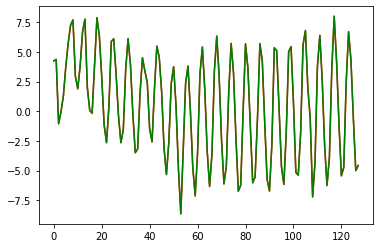

In [78]:
start=100
ts=pcs.A.sel(mode=0).isel(time=slice(start,start+128)).data
wavelet='haar'
(cA, cD) = pywt.dwt(ts, 'db2', 'smooth')
coeffs = pywt.wavedec(ts, wavelet=wavelet,level=4)

tsn=pywt.idwt(cA=cA,cD=None,wavelet='db1')
tst=pywt.downcoef('a', ts, wavelet, mode='symmetric', level=1)
# coeffs[1] = np.zeros_like(coeffs[1])
# coeffs[2] = np.zeros_like(coeffs[2])
# coeffs[3] = np.zeros_like(coeffs[3])
# coeffs[4] = np.zeros_like(coeffs[4])
# coeffs[0] = np.zeros_like(coeffs[0])
# coeffs[-1] = np.zeros_like(coeffs[-1])
tsm=pywt.waverec(coeffs, wavelet=wavelet)
plt.plot(ts,'r-')
#plt.plot(tsn,'r-')
plt.plot(tsm,'g-')

In [79]:
np.shape(tst)

(64,)

In [80]:
features=[]
for coeff in coeffs:
    features += get_features(coeff)

np.shape(features)

(60,)

In [81]:
coeffs

[array([14.626402  ,  9.399781  ,  2.4899595 , -2.8686278 , -4.6038127 ,
        -1.01774   ,  0.8437772 , -0.64952195], dtype=float32),
 array([-1.8503838 , -0.6798792 ,  1.9629029 , -2.3485677 ,  0.02574635,
         3.99812   , -5.375926  ,  2.8259406 ], dtype=float32),
 array([-3.7089815 , -0.05212259,  6.489313  ,  3.2703483 , -5.290063  ,
         1.9534938 ,  6.49018   , -5.3101044 , -3.7541895 ,  7.4773436 ,
        -0.64559793, -7.866016  ,  4.995854  ,  5.352899  , -8.851614  ,
         1.714972  ], dtype=float32),
 array([  4.859575  ,  -3.9734812 ,   2.4698987 ,   6.2012906 ,
         -5.3227053 ,   2.0150633 ,   4.648406  ,  -6.947896  ,
          5.147896  ,   0.12326694,  -5.7159843 ,   7.3039236 ,
         -2.251917  ,  -6.2526503 ,   7.8802376 ,  -3.780116  ,
         -4.7378488 ,   8.919985  ,  -5.9397573 ,  -1.3669026 ,
          8.278688  ,  -8.00881   ,   1.4334893 ,   7.418462  ,
         -9.199635  ,   1.41398   ,   5.519459  , -10.822953  ,
          4.971225  ,

In [52]:
np.shape(np.vstack((features,ff)))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 9 and the array at index 1 has size 11

In [41]:
ff=features
ff

[0.0,
 0.0,
 0.6931471805599453,
 1.3862943611198906,
 2.0794415416798357,
 2.772588722239781,
 3.4657359027997265,
 4.1588830833596715,
 4.852030263919617,
 5.545177444479562,
 6.2383246250395095]

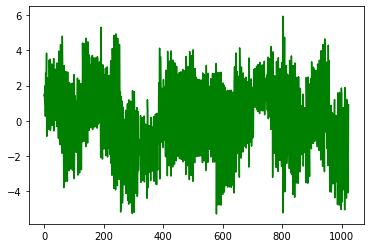

In [391]:
plt.plot(ts-tsm,'g-')

In [358]:
coeffs

[array([  7.702077, -39.524193], dtype=float32),
 array([1.3529294, 0.       ], dtype=float32),
 array([17.67728  , -5.5030026, 35.119217 ], dtype=float32),
 array([12.423834, 11.145011,  6.137113, 12.926641, -9.371059, 45.89005 ],
       dtype=float32),
 array([-9.244692  , -7.613444  , 12.155907  , -4.092545  ,  1.314383  ,
         3.5204852 ,  0.50240326, -0.06099248,  4.4025865 ,  9.700112  ,
        -8.065258  , 58.483543  ], dtype=float32),
 array([ 0.11671591, -2.1996813 ,  2.3194332 , -4.488669  ,  1.8944468 ,
         6.1045465 , -4.342495  , -3.2876828 , -1.7861972 , -1.9190127 ,
         3.7919388 , -5.5859995 , -9.247363  ,  3.7556865 ,  4.982523  ,
        -0.2893933 , 14.035786  , -0.96622944,  2.3058033 , -7.7224884 ,
         5.8117228 ,  3.401446  , 13.421504  ,  0.        ], dtype=float32),
 array([ 2.9629402 , -8.372102  ,  2.0933313 , -0.6259804 ,  6.779351  ,
         5.1551404 ,  1.5700674 , -7.7015476 , -5.6606603 ,  0.1762712 ,
         2.841128  ,  7.0274315 ,

In [295]:
arr=[]
for ii in np.arange(2):
    ts=pcs.A.sel(mode=0).isel(time=slice(100+ii*10,164+10*ii)).data
    (cA, cD) = pywt.dwt(ts, 'db2', 'smooth')
    arr.append(cD.T)

arr

[array([-5.9604645e-08, -2.3858392e+00, -5.8488017e-01,  2.7561206e-01,
         2.6429968e+00, -1.9296067e+00,  7.5792718e-01, -9.7897518e-01,
        -2.2391796e+00,  2.6967790e+00,  5.3540254e-01, -2.5324593e+00,
         2.2230115e+00,  6.5736371e-01, -1.7679971e+00,  7.0657837e-01,
         1.5321780e+00, -1.8383046e+00,  3.0458841e-01,  4.5230892e-01,
        -9.9156237e-01, -3.1653315e-01,  1.5582800e+00, -9.6205503e-01,
        -1.7329130e+00,  2.7237301e+00, -4.2633480e-01, -1.3693221e+00,
         3.0604131e+00, -1.0428246e+00, -2.2344623e+00,  3.3723383e+00,
        -5.9604645e-08], dtype=float32),
 array([ 8.9406967e-08,  7.5792718e-01, -9.7897518e-01, -2.2391796e+00,
         2.6967790e+00,  5.3540254e-01, -2.5324593e+00,  2.2230115e+00,
         6.5736371e-01, -1.7679971e+00,  7.0657837e-01,  1.5321780e+00,
        -1.8383046e+00,  3.0458841e-01,  4.5230892e-01, -9.9156237e-01,
        -3.1653315e-01,  1.5582800e+00, -9.6205503e-01, -1.7329130e+00,
         2.7237301e+00,

In [266]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(pcs.A.data)
np.min(X)

-5.9232216

In [269]:

db = DBSCAN(eps=1, min_samples=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 1
Estimated number of noise points: 1489


NameError: name 'labels_true' is not defined

[Text(0, 0.2, '0.2'),
 Text(0, 0.5, '0.5'),
 Text(0, 0.6, '0.6'),
 Text(0, 1.0, '1')]

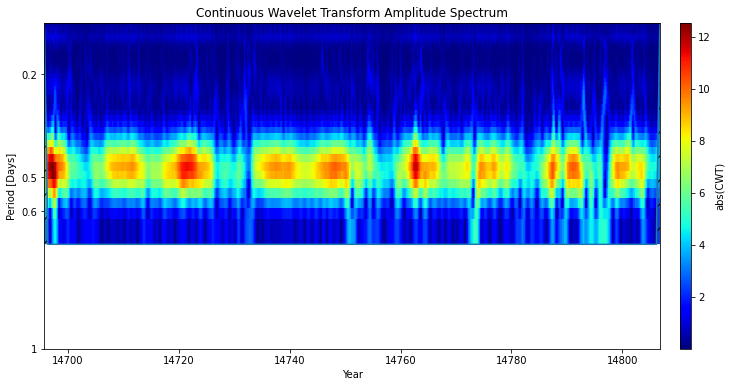

In [39]:
scales = np.logspace(0.01, 1.1, num=50)

#scales = np.arange(15,600, 4)
ax = scg.cws(date2num(res['time']), ts, scales, figsize=(12,6),ylabel="Period [Days]", xlabel='Year')#, yscale='log')
ax.set_yticks([0.2,0.5,0.6,1])
ax.set_yticklabels([0.2,0.5,0.6, 1,])

In [58]:
sp.signal.cwt(ts,sp.signal.ricker,np.arange(1,31))

array([[ 4.25667161e+00,  1.09585968e+01,  2.75321683e+00, ...,
         2.62720317e+00, -3.26976690e+00, -9.63667427e+00],
       [ 9.56999583e+00,  1.03311946e+01,  1.94001797e+00, ...,
        -1.68749584e+00, -7.46110243e+00, -8.73994281e+00],
       [ 6.11540561e+00,  4.42372374e+00,  6.43564827e-01, ...,
        -7.09562219e+00, -7.15639266e+00, -5.36592839e+00],
       ...,
       [ 9.34275942e-02,  3.95756372e-02, -3.00189630e-02, ...,
        -3.66576230e+01, -3.43748544e+01, -3.20265524e+01],
       [-3.30755880e-01, -3.91706902e-01, -4.66019036e-01, ...,
        -3.77186057e+01, -3.55457904e+01, -3.33054635e+01],
       [-7.41666086e-01, -8.06459850e-01, -8.82489584e-01, ...,
        -3.86566239e+01, -3.65916967e+01, -3.44580426e+01]])

## Cross corr fine-coarse

In [ ]:
HRdata=surface.sel(Y=slice(6733400,6737500),X=slice(-40000,-35000))

Text(0.5, 1.0, 'Standard deviation v velocity')

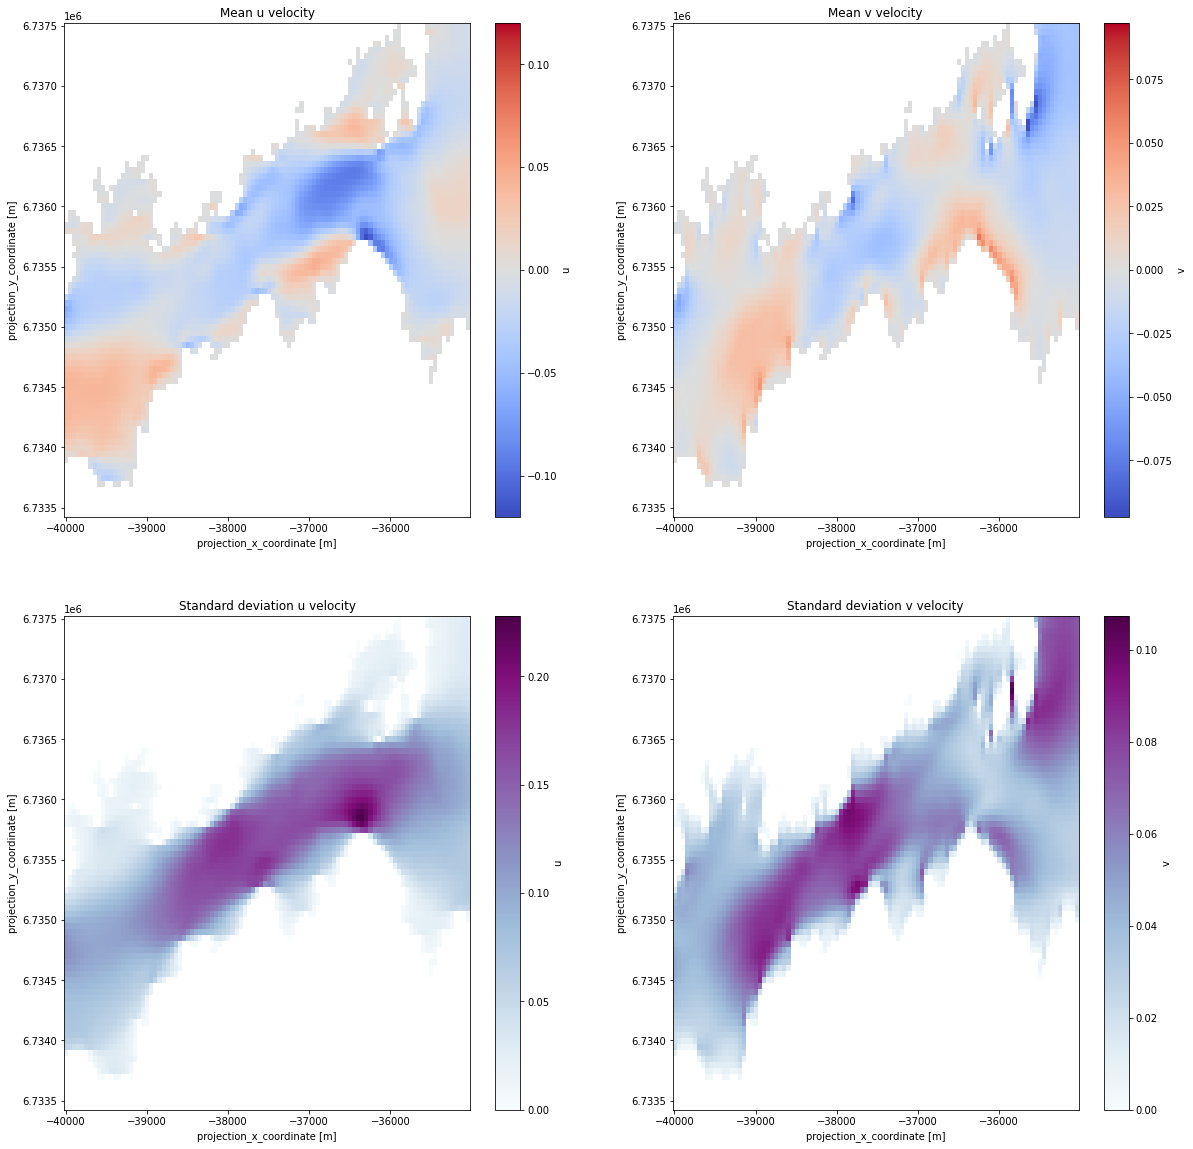

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
cmap='coolwarm'
cmap_std='BuPu'
HRdata.u.mean(dim='time').where(HRdata.land_binary_mask==0).plot(ax=axes[0,0],cmap=cmap)
axes[0,0].set_title('Mean u velocity')
HRdata.v.mean(dim='time').where(HRdata.land_binary_mask==0).plot(ax=axes[0,1],cmap=cmap)
axes[0,1].set_title('Mean v velocity')
HRdata.u.std(dim='time').where(HRdata.land_binary_mask==0).plot(ax=axes[1,0],cmap=cmap_std)
axes[1,0].set_title('Standard deviation u velocity')
HRdata.v.std(dim='time').where(HRdata.land_binary_mask==0).plot(ax=axes[1,1],cmap=cmap_std)
axes[1,1].set_title('Standard deviation v velocity')


In [ ]:
yname='Y'
xname='X'
skip=6
LRdata=HRdata.isel(Y=slice(0,HRdata.dims[yname],skip),X=slice(0,HRdata.dims[xname],skip))

Text(0.5, 1.0, 'Standard deviation v velocity')

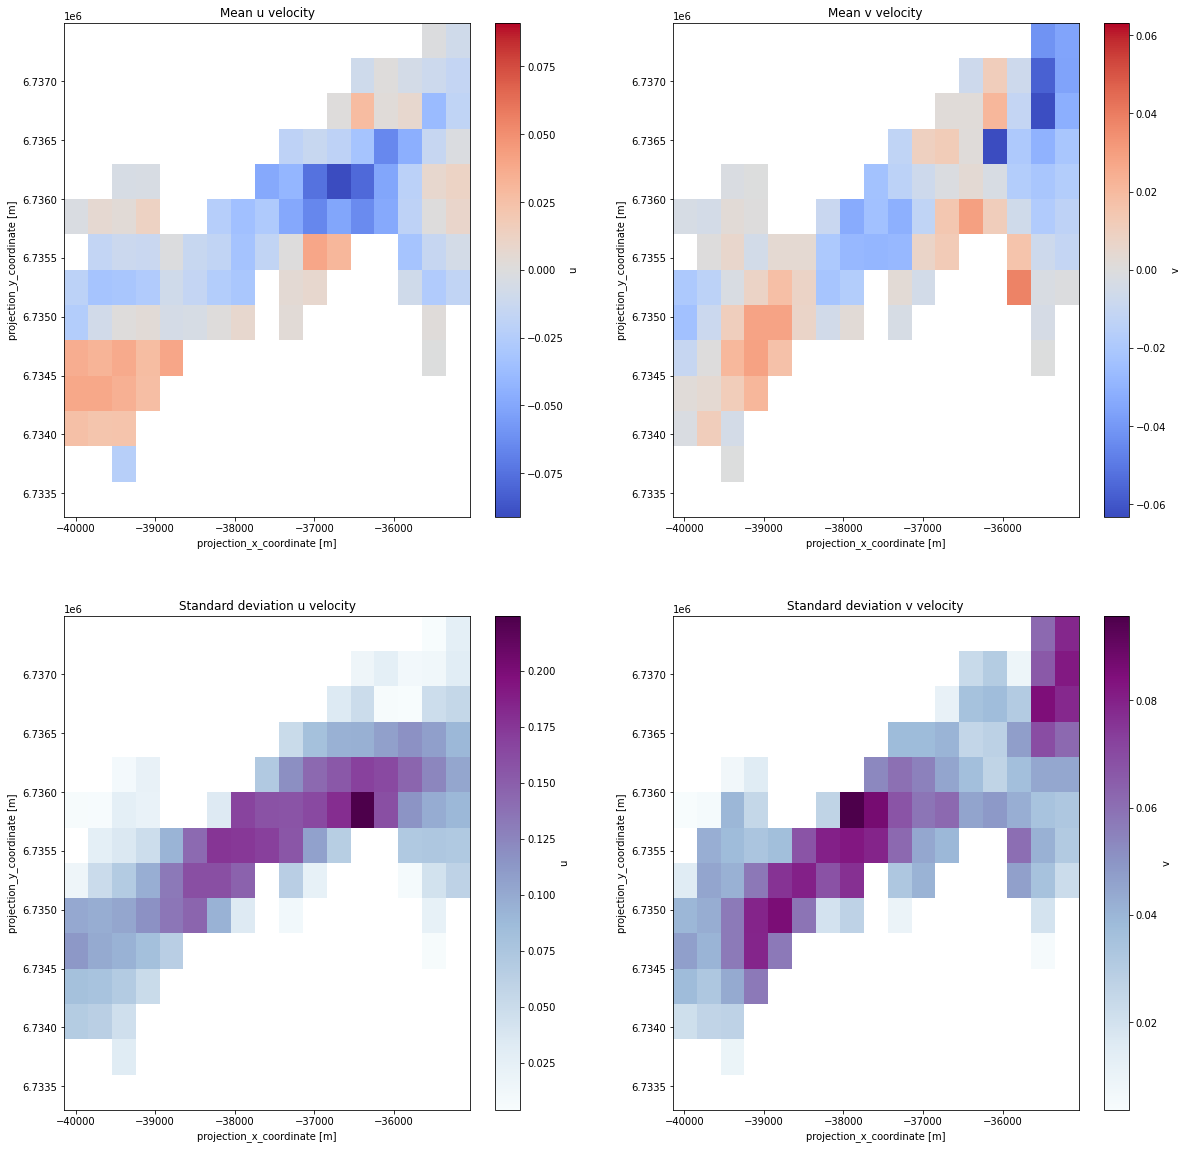

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
cmap='coolwarm'
cmap_std='BuPu'
LRdata.u.mean(dim='time').where(LRdata.land_binary_mask==0).plot(ax=axes[0,0],cmap=cmap)
axes[0,0].set_title('Mean u velocity')
LRdata.v.mean(dim='time').where(LRdata.land_binary_mask==0).plot(ax=axes[0,1],cmap=cmap)
axes[0,1].set_title('Mean v velocity')
LRdata.u.std(dim='time').where(LRdata.land_binary_mask==0).plot(ax=axes[1,0],cmap=cmap_std)
axes[1,0].set_title('Standard deviation u velocity')
LRdata.v.std(dim='time').where(LRdata.land_binary_mask==0).plot(ax=axes[1,1],cmap=cmap_std)
axes[1,1].set_title('Standard deviation v velocity')


In [ ]:
def create_vel(data):
    data['vel']=xr.concat([data['u'],data['v']] ,dim='comp')
    data=data.stack(z=['comp','Y','X'])
    data=data.where(data.land_binary_mask==0,drop=True).dropna(dim='time')
    return data

def norm_vel(data):
    out=((data-data.mean(dim='time')))#/data.std(dim='time'))
    return out.dropna(dim='z')
#LRvel=xr.concat([LRdata['u'],LRdata['v']] ,dim='comp')

In [ ]:
HRvel=create_vel(HRdata)['vel']
LRvel=create_vel(LRdata)['vel']

In [ ]:
HRnorm=norm_vel(HRvel)
LRnorm=norm_vel(LRvel)

In [ ]:
LRvel

<xarray.DataArray 'vel' (time: 1501, z: 196)>
array([[-0.0551476 ,  0.01174853,  0.03578741, ...,  0.08330455,
         0.04893956,  0.0587655 ],
       [-0.03705893,  0.00864483,  0.0177404 , ...,  0.02797446,
        -0.03271115,  0.01471524],
       [-0.04463166, -0.06056198, -0.04702141, ..., -0.08073766,
        -0.10956556, -0.05944214],
       ...,
       [-0.03264773, -0.06113115, -0.064557  , ..., -0.36713946,
        -0.24694295, -0.3555003 ],
       [-0.02868588,  0.03920212, -0.02433619, ..., -0.34373873,
        -0.24446808, -0.32651347],
       [-0.00799333,  0.16502129,  0.12401505, ..., -0.32733768,
        -0.21551655, -0.29502633]], dtype=float32)
Coordinates:
    depth    float32 1.0
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-16T18:40:00
  * z        (z) MultiIndex
  - comp     (z) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
  - Y        (z) float64 6.734e+06 6.734e+06 6.734e+06 ... 6.737e+06 6.737e+06
  - X        (z) float64 -3.939e+04 -3.999e+04 ... -3.549e+04 -3.519e+04
Attributes:
    units:          meter second-1
    time:           ocean_time
    field:          u-velocity, scalar, series
    grid_mapping:   projection_stere
    long_name:      Sea water x velocity
    standard_name:  x_sea_water_velocity

In [ ]:
C=(1/1500)*HRnorm.data.T@LRnorm.data

In [ ]:
U,L,Vt = np.linalg.svd(C)
V=Vt.T

U=U[:,0:10]
V=V[:,0:10]
L=L[0:10]

In [ ]:
A=HRnorm.data@U
B=LRnorm.data@V

In [ ]:
uf=xr.DataArray(A@U.T,coords=HRnorm.coords)
vf=xr.DataArray(B@V.T,coords=LRnorm.coords)


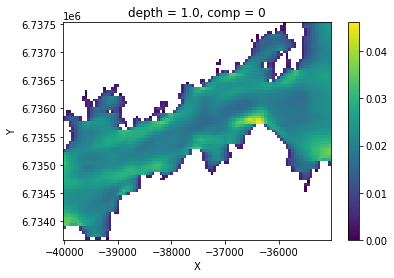

In [ ]:
(uf-HRnorm).std(dim='time').unstack('z').isel(comp=0).plot()

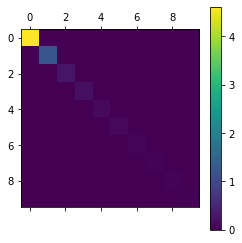

In [ ]:
plt.matshow((A-A.mean(axis=0)).T@(B-B.mean(axis=0))/1500)
plt.colorbar()

In [ ]:
U

array([[ 3.83895440e-06,  4.03594808e-04,  6.39574195e-04, ...,
         3.11101496e-04,  9.08863265e-04, -9.24636988e-05],
       [-6.21268964e-06,  4.16153111e-04,  6.70103298e-04, ...,
         2.99452571e-04,  8.01909948e-04, -1.09693676e-04],
       [ 2.53232865e-04,  2.28864650e-04, -1.06060717e-04, ...,
        -8.76659062e-04,  3.20902363e-05,  1.19864219e-03],
       ...,
       [-8.14827252e-03,  1.85044727e-03, -3.31741832e-02, ...,
         1.03231436e-02,  3.96297267e-03,  1.85171738e-02],
       [-7.98618887e-03,  2.50808639e-03, -3.10624707e-02, ...,
         8.11454374e-03,  5.49258804e-03,  2.06322763e-02],
       [-7.79969990e-03,  2.91161239e-03, -2.87246201e-02, ...,
         5.75634837e-03,  5.75837260e-03,  2.17000842e-02]], dtype=float32)